## 1. Data Download

This section downloads the necessary image files and the ImageNet class labels from a GitHub repository. These files will be used as inputs for the GradCAM analysis.

- `A12A_x2700_007.png`, `E14F.png`, `F13G.png`: These are custom spore images used to test the GradCAM implementations on a different type of data than standard ImageNet images.
- `dog.jpg`, `tiger_shark.jpeg`: These are standard images from the ImageNet dataset, commonly used for testing computer vision models.
- `imagenet_class_labels.pkl`: This file contains the mapping from ImageNet class indices to human-readable labels.

In [19]:
!wget https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/A12A_x2700_007.png?raw=true -O A12A_x2700_007.png
!wget https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/E14F.png?raw=true -O E14F.png
!wget https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/F13G.png?raw=true -O F13G.png
!wget https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/dog.jpg?raw=true -O dog.jpg
!wget https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/tiger_shark.jpeg?raw=true -O tiger_shark.jpeg
!wget https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/imagenet_class_labels.pkl?raw=true -O imagenet_class_labels.pkl

--2025-08-05 14:18:58--  https://github.com/CeadeS/exp_cnn_gradcam_comp/blob/main/A12A_x2700_007.png?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/CeadeS/exp_cnn_gradcam_comp/raw/refs/heads/main/A12A_x2700_007.png [following]
--2025-08-05 14:18:58--  https://github.com/CeadeS/exp_cnn_gradcam_comp/raw/refs/heads/main/A12A_x2700_007.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CeadeS/exp_cnn_gradcam_comp/refs/heads/main/A12A_x2700_007.png [following]
--2025-08-05 14:18:58--  https://raw.githubusercontent.com/CeadeS/exp_cnn_gradcam_comp/refs/heads/main/A12A_x2700_007.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (

## 2. Library Installation and Setup

This section handles the installation of the required Python libraries: `pytorch-grad-cam` and `explainable-cnn`. It also includes steps to address potential compatibility issues with the `explainable-cnn` library by installing it in editable mode and modifying its source code to fix a deprecated NumPy usage error (`np.float`).

- `pytorch-grad-cam`: A widely used library for generating GradCAM visualizations.
- `explainable-cnn`: Another library for generating explanations for CNNs, including GradCAM.

**Note**: The `sed` command is used to directly modify the installed `explainable-cnn` code to fix a specific error related to NumPy versions. This is a workaround for a compatibility issue in the library.

In [ ]:
# Uninstall the current version of explainable-cnn
!pip uninstall explainable-cnn -y
# Clone the repository
!git clone https://github.com/ashutosh1919/explainable-cnn
# Install in editable mode
!pip install -e explainable-cnn
!sed -i 's/np.float/float/g' explainable-cnn/src/explainable_cnn/explainers/cnn_explainer.py
print("Modified explainable_cnn/explainers/cnn_explainer.py to replace np.float with float due to deprecation in numpy")

## 3. GradCAM Comparison

This section contains the core code for comparing the two GradCAM implementations. It defines functions for loading models (ImageNet pre-trained and custom), preprocessing images, making predictions, computing GradCAM using both libraries, and visualizing the results.

The `process_image` function handles images for the ImageNet model, while `process_custom_image` handles images for the custom model. The `create_combined_visualization` function generates a single plot showing the comparison for all processed images.

In the output of this section, you will see comparison plots for each image:

-   **Original Image**: The input image.
-   **Standard GradCAM**: The heatmap generated by `pytorch-grad-cam`. This serves as a reference.
-   **Explainable-CNN**: The heatmap generated by `explainable-cnn`.

Pay close attention to the difference in the heatmaps between the "Standard GradCAM" and "Explainable-CNN" columns. You may observe a color inversion or different intensity patterns in the `explainable-cnn` output, highlighting the issue this notebook aims to demonstrate.

GRADCAM IMPLEMENTATION COMPARISON
1. Loading Model and Classes...
Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2. Loading and processing image...
3. Making prediction...
   Prediction: tiger shark (Confidence: 0.9992)
4. Computing Standard GradCAM...
5. Computing Explainable-CNN GradCAM...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


   Used Layer: layer 4
6. Creating comparison plot...


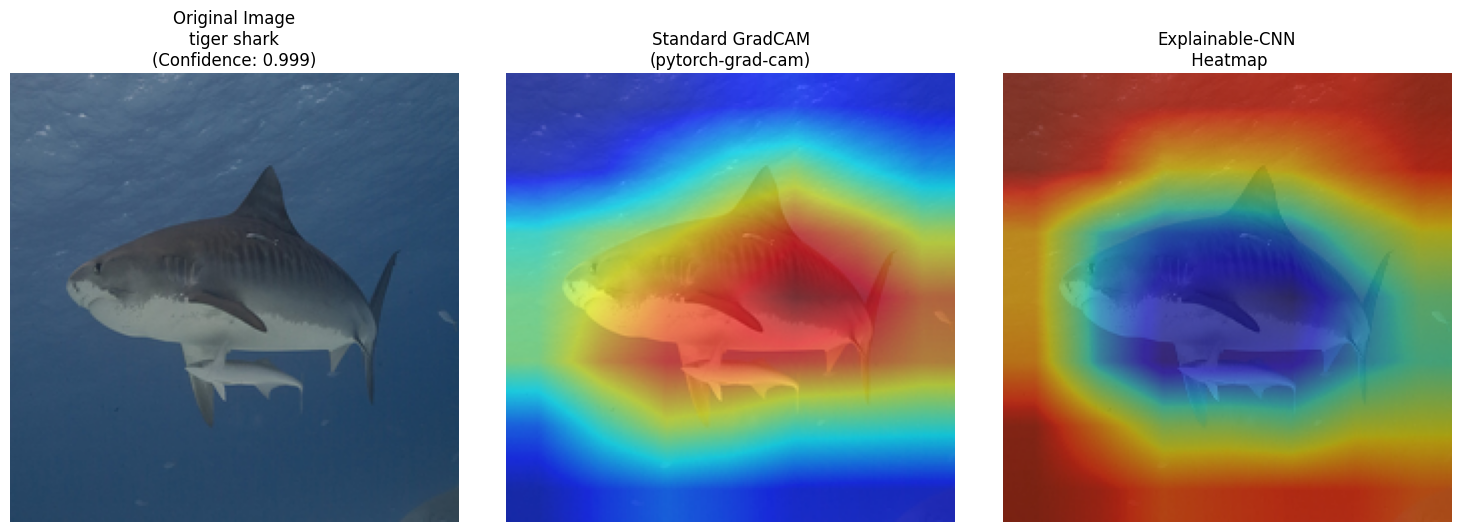

In [6]:
#!/usr/bin/env python3
"""
Simple script to test your own image with both GradCAM implementations
to demonstrate the problem with inverted colors.

"""

import sys
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import pickle # Import pickle

# Standard GradCAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Problematische Implementierung
from explainable_cnn import CNNExplainer

def load_imagenet_classes():
    """Load ImageNet classes"""
    try:
        imagenet_classes_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(imagenet_classes_url)
        imagenet_classes = response.text.strip().split('\n')
        imagenet_class_labels = {i: label for i, label in enumerate(imagenet_classes)}
        return imagenet_classes, imagenet_class_labels
    except:
        print("Warning: Could not load ImageNet classes. Using placeholders.")
        return [f"class_{i}" for i in range(1000)], {i: f"class_{i}" for i in range(1000)}

def setup_model_and_preprocessing():
    """Setup model and preprocessing"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load ResNet50
    model = models.resnet50(pretrained=True)
    model.eval()
    model = model.to(device)

    # Standard ImageNet Preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return model, preprocess, device

def predict_image(model, img_tensor, device, imagenet_classes):
    """Make prediction for image"""
    input_batch = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)
        predicted_class = output.argmax(dim=1).item()
        confidence = torch.nn.functional.softmax(output, dim=1)[0, predicted_class].item()

    return predicted_class, confidence, input_batch

def compute_standard_gradcam(model, input_batch, predicted_class, rgb_img):
    """Standard GradCAM with pytorch-grad-cam"""
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(predicted_class)]

    grayscale_cam = cam(input_tensor=input_batch, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    standard_gradcam = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    return grayscale_cam, standard_gradcam

def compute_explainable_cnn_gradcam(model, img_path, predicted_class, imagenet_classes, imagenet_class_labels, device):
    """GradCAM with explainable-cnn"""
    # Ensure class_labels are available or load them
    if not imagenet_class_labels:
          _, imagenet_class_labels = load_imagenet_classes()

    x_cnn = CNNExplainer(model, imagenet_class_labels)
    grad_cam = x_cnn.get_grad_cam(
        img_path,
        3,
        (224, 224),
        ["layer4"]  # List of layer names for which you want to generate image.
    )
    cnn_explainer_gradcam_image = grad_cam[0].astype('uint8')
    # Note that get_grad_cam() returns list of images (numpy array)
    return cnn_explainer_gradcam_image, 'layer 4'

    #raise Exception("All layers failed") # This line seems unnecessary if returning


def create_comparison_plot(rgb_img, standard_gradcam, standard_heatmap,
                         problematic_overlay, predicted_class, imagenet_classes, confidence):
    """Create comparison plot"""
    plt.figure(figsize=(20, 10))

    # Original Image
    plt.subplot(2, 4, 1)
    plt.imshow(rgb_img)
    plt.title(f'Original Image\n{imagenet_classes[predicted_class]}\n(Confidence: {confidence:.3f})', fontsize=12)
    plt.axis('off')

    # Standard GradCAM
    plt.subplot(2, 4, 2)
    plt.imshow(standard_gradcam)
    plt.title('Standard GradCAM\n(pytorch-grad-cam)', fontsize=12)
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.imshow(problematic_overlay)
    plt.title('Explainable-CNN\n Heatmap', fontsize=12) # Changed title to Heatmap
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def show_corrected_version(rgb_img, standard_gradcam, problematic_heatmap):
    """Show corrected version"""
    # Ensure rgb_img is in the correct format (0-255) for cv2
    rgb_img_cv2 = (rgb_img * 255).astype(np.uint8)

    corrected_heatmap = 1 - problematic_heatmap

    corrected_overlay = cv2.addWeighted(
        rgb_img_cv2, 0.6,
        cv2.applyColorMap((corrected_heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET), 0.4,
        0
    )

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(standard_gradcam)
    plt.title('Standard GradCAM\n(Reference)', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    problematic_overlay = cv2.addWeighted(
        rgb_img_cv2, 0.6,
        cv2.applyColorMap((problematic_heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET), 0.4,
        0
    )
    plt.imshow(cv2.cvtColor(problematic_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Explainable-CNN\n(Original - Problematic)', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(corrected_overlay, cv2.COLOR_BGR2RGB))
    plt.title('Explainable-CNN\n(Corrected - Inverted)', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


    return None

def main(image_path):
    """Main function"""
    if not os.path.exists(image_path):
        print(f"Error: Image {image_path} not found!")
        return

    print("=" * 60)
    print("GRADCAM IMPLEMENTATION COMPARISON")
    print("=" * 60)

    # Setup
    print("1. Loading Model and Classes...")
    imagenet_classes, imagenet_class_labels = load_imagenet_classes()
    model, preprocess, device = setup_model_and_preprocessing()

    # Load and preprocess image
    print("2. Loading and processing image...")
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img)
    rgb_img = np.array(img.resize((224, 224))) / 255.0

    # Prediction
    print("3. Making prediction...")
    predicted_class, confidence, input_batch = predict_image(model, input_tensor, device, imagenet_classes)
    print(f"   Prediction: {imagenet_classes[predicted_class]} (Confidence: {confidence:.4f})")

    # Standard GradCAM
    print("4. Computing Standard GradCAM...")
    standard_heatmap, standard_gradcam = compute_standard_gradcam(model, input_batch, predicted_class, rgb_img)

    # Explainable-CNN GradCAM
    print("5. Computing Explainable-CNN GradCAM...")
    problematic_heatmap, used_layer = compute_explainable_cnn_gradcam(
        model, image_path, predicted_class, imagenet_classes, imagenet_class_labels, device
    )

    if used_layer:
        print(f"   Used Layer: {used_layer}")

    # Comparison Plot
    print("6. Creating comparison plot...")
    create_comparison_plot(
        rgb_img, standard_gradcam, standard_heatmap,
        problematic_heatmap, predicted_class, imagenet_classes, confidence
    )

if __name__ == "__main__":
    # Example usage with test images
    # Make sure these images exist in your environment or provide their paths
    # image_path = "dog.jpg"
    image_path = "tiger_shark.jpeg"
    main(image_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


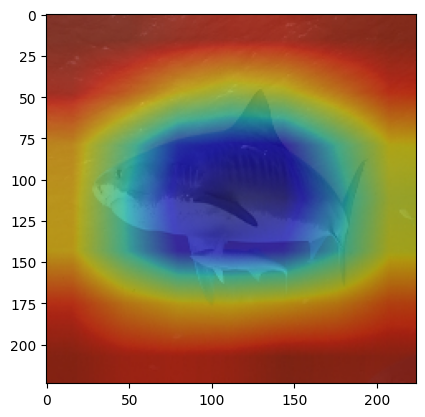

In [7]:
from explainable_cnn import CNNExplainer
import pickle
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image # Import Image
import numpy as np # Import numpy

model = models.resnet18(pretrained=True)
with open("imagenet_class_labels.pkl", "rb") as label_file:
    imagenet_class_labels = pickle.load(label_file)
x_cnn = CNNExplainer(model, imagenet_class_labels)
grad_cam = x_cnn.get_grad_cam(
    "tiger_shark.jpeg",
    3,
    (224, 224),
    ["layer4"]  # List of layer names for which you want to generate image.
)
cnn_explainer_gradcam_image = grad_cam[0].astype('uint8')
# Note that get_grad_cam() returns list of images (numpy array)
plt.imshow(cnn_explainer_gradcam_image) # Add the image data to imshow
plt.show() # Add plt.show() to display the plot

PROCESSING IMAGENET IMAGES
Processing dog.jpg with ImageNet model...


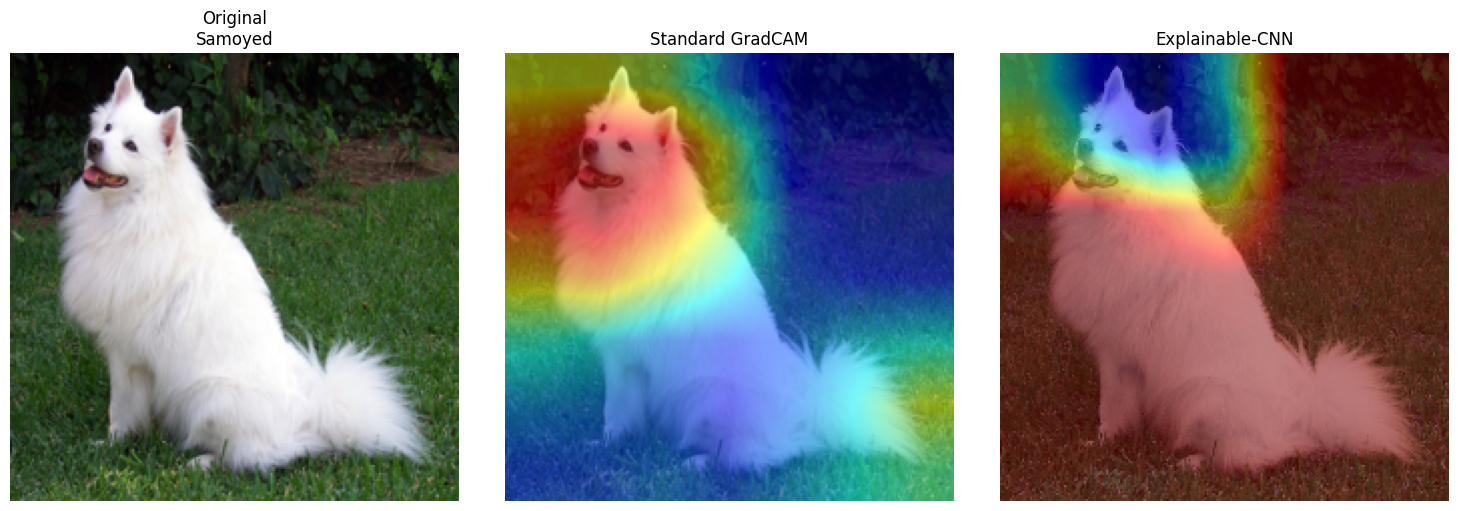

Processing tiger_shark.jpeg with ImageNet model...


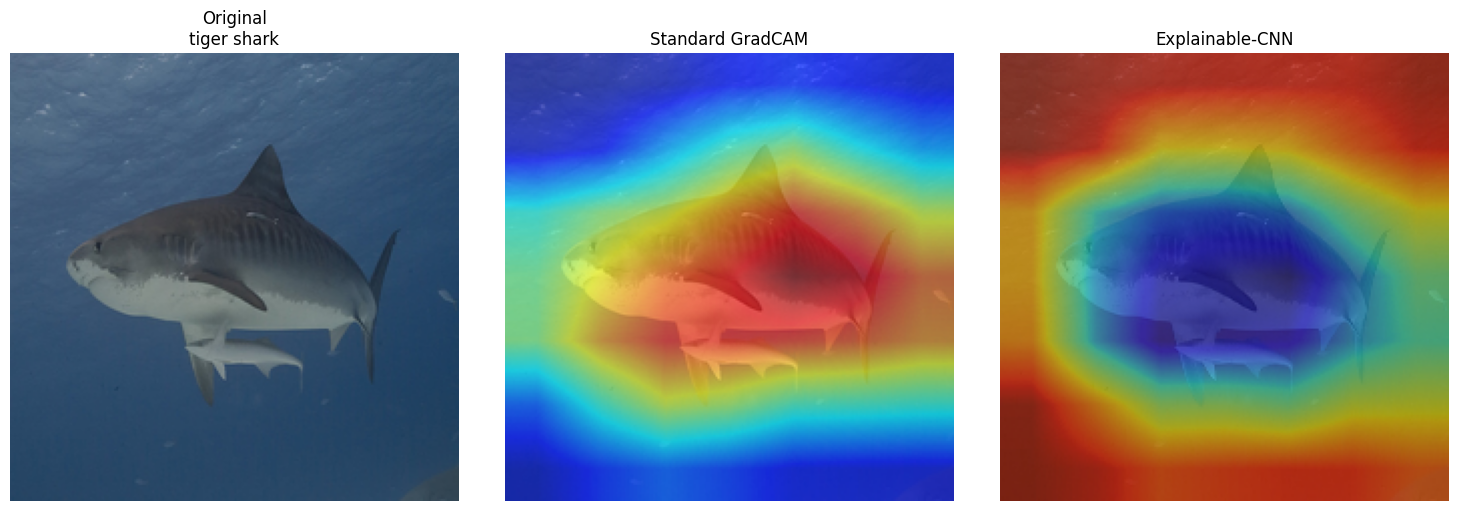


PROCESSING SPORE IMAGES WITH CUSTOM MODEL
Processing A12A_x2700_007.png with custom model...
Error processing A12A_x2700_007.png: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'
Processing E14F.png with custom model...
Error processing E14F.png: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'
Processing F13G.png with custom model...
Error processing F13G.png: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'


In [8]:
#!/usr/bin/env python3

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import InterpolationMode
from torchvision.transforms._presets import ImageClassification
try:
    from torchvision.transforms._presets import DefaultClassificationPresetEval
except ImportError:
    # Fallback for older torchvision versions
    DefaultClassificationPresetEval = ImageClassification
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from explainable_cnn import CNNExplainer

def load_imagenet_classes():
    try:
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        classes = response.text.strip().split('\n')
        class_labels = {i: label for i, label in enumerate(classes)}
        return classes, class_labels
    except:
        classes = [f"class_{i}" for i in range(1000)]
        class_labels = {i: f"class_{i}" for i in range(1000)}
        return classes, class_labels

def setup_model():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.resnet50(pretrained=True)
    model.eval()
    model = model.to(device)

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return model, preprocess, device

def setup_custom_model(checkpoint_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    model = models.get_model(ckpt['args'].model,
                             num_classes=ckpt['model']['fc.weight'].shape[0])
    model.load_state_dict(ckpt['model'])
    model.eval()
    model = model.to(device)

    preprocessing = DefaultClassificationPresetEval(
        crop_size=ckpt['args'].val_crop_size,
        resize_size=ckpt['args'].val_resize_size,
        interpolation=InterpolationMode(ckpt['args'].interpolation)
    )

    return model, preprocessing, device

def get_prediction(model, img_tensor, device):
    if isinstance(img_tensor, torch.Tensor):
        input_batch = img_tensor.unsqueeze(0).to(device)
    else:
        input_batch = img_tensor.to(device)

    with torch.no_grad():
        output = model(input_batch)
        predicted_class = output.argmax(dim=1).item()
    return predicted_class, input_batch

def get_standard_gradcam(model, input_batch, predicted_class, rgb_img):
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(predicted_class)]

    grayscale_cam = cam(input_tensor=input_batch, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    return show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

def get_explainable_cnn_gradcam(model, img_path, class_labels):
    try:
        x_cnn = CNNExplainer(model, class_labels)
        grad_cam = x_cnn.get_grad_cam(img_path, 3, (224, 224), ["layer4"])
        return grad_cam[0].astype('uint8')
    except Exception as e:
        print(f"Error with explainable-cnn: {e}")
        return None

def process_image(image_path):
    print(f"Processing {image_path} with ImageNet model...")

    imagenet_classes, class_labels = load_imagenet_classes()
    model, preprocess, device = setup_model()

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img)
    rgb_img = np.array(img.resize((224, 224))) / 255.0

    # Get prediction
    predicted_class, input_batch = get_prediction(model, input_tensor, device)

    # Generate GradCAMs
    standard_gradcam = get_standard_gradcam(model, input_batch, predicted_class, rgb_img)
    explainable_gradcam = get_explainable_cnn_gradcam(model, image_path, class_labels)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f'Original\n{imagenet_classes[predicted_class]}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(standard_gradcam)
    plt.title('Standard GradCAM')
    plt.axis('off')

    if explainable_gradcam is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(explainable_gradcam)
        plt.title('Explainable-CNN')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_custom_image(image_path, checkpoint_path):
    print(f"Processing {image_path} with custom model...")

    model, preprocess, device = setup_custom_model(checkpoint_path)

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img)

    # For display purposes, resize to 224x224
    display_img = img.resize((224, 224))
    rgb_img = np.array(display_img) / 255.0

    # Get prediction
    predicted_class, input_batch = get_prediction(model, input_tensor, device)

    # Create dummy class labels for custom model
    num_classes = model.fc.out_features
    custom_class_labels = {i: f"class_{i}" for i in range(num_classes)}

    # Generate GradCAMs
    standard_gradcam = get_standard_gradcam(model, input_batch, predicted_class, rgb_img)
    explainable_gradcam = get_explainable_cnn_gradcam(model, image_path, custom_class_labels)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f'Original\nPredicted class: {predicted_class}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(standard_gradcam)
    plt.title('Standard GradCAM')
    plt.axis('off')

    if explainable_gradcam is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(explainable_gradcam)
        plt.title('Explainable-CNN')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Process ImageNet images
    print("=" * 50)
    print("PROCESSING IMAGENET IMAGES")
    print("=" * 50)
    process_image("dog.jpg")
    process_image("tiger_shark.jpeg")

    # Process custom model images
    print("\n" + "=" * 50)
    print("PROCESSING SPORE IMAGES WITH CUSTOM MODEL")
    print("=" * 50)
    checkpoint_path = "spores_model_cv_1_37.pth"

    custom_images = ["A12A_x2700_007.png", "E14F.png", "F13G.png"]
    for img_path in custom_images:
        try:
            process_custom_image(img_path, checkpoint_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

PROCESSING IMAGENET IMAGES
Processing dog.jpg with ImageNet model...


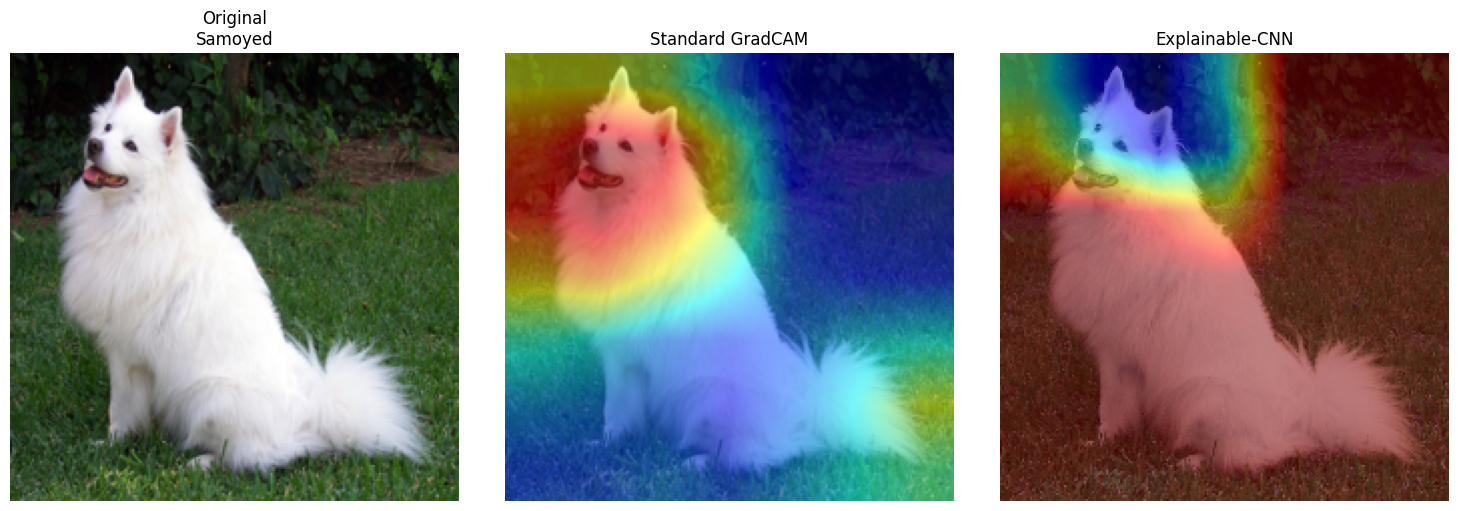

Processing tiger_shark.jpeg with ImageNet model...


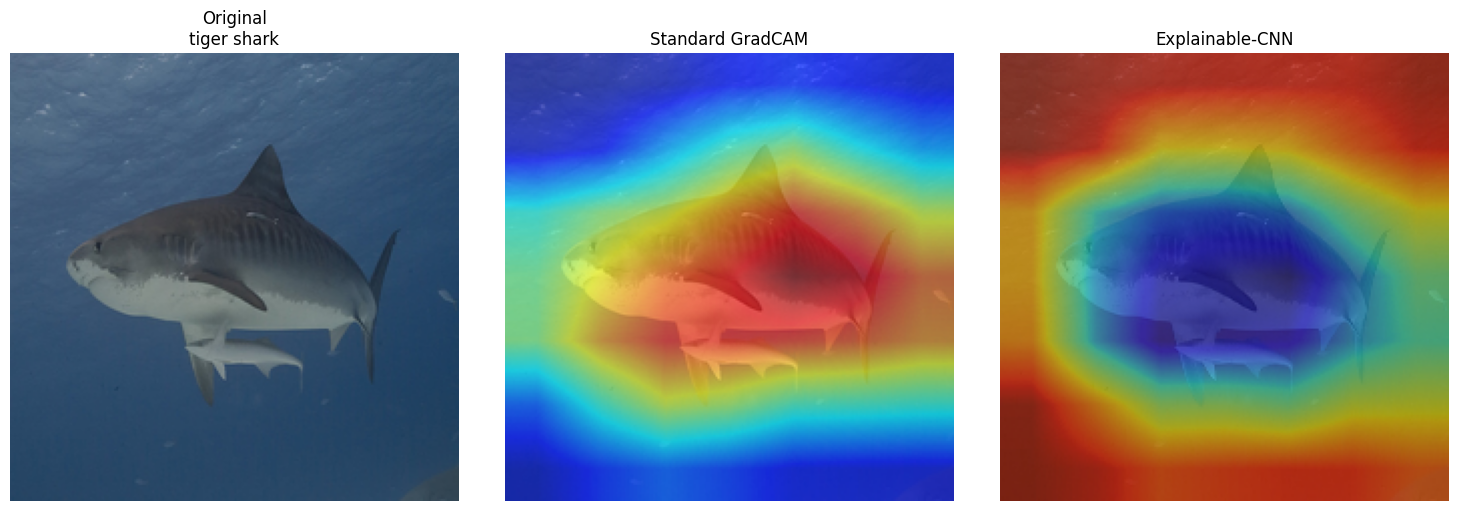


PROCESSING SPORE IMAGES WITH CUSTOM MODEL
Processing A12A_x2700_007.png with custom model...
Error processing A12A_x2700_007.png: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'
Processing E14F.png with custom model...
Error processing E14F.png: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'
Processing F13G.png with custom model...
Error processing F13G.png: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'

CREATING COMBINED VISUALIZATION

Creating combined visualization...
Error loading custom model: [Errno 2] No such file or directory: 'spores_model_cv_1_37.pth'


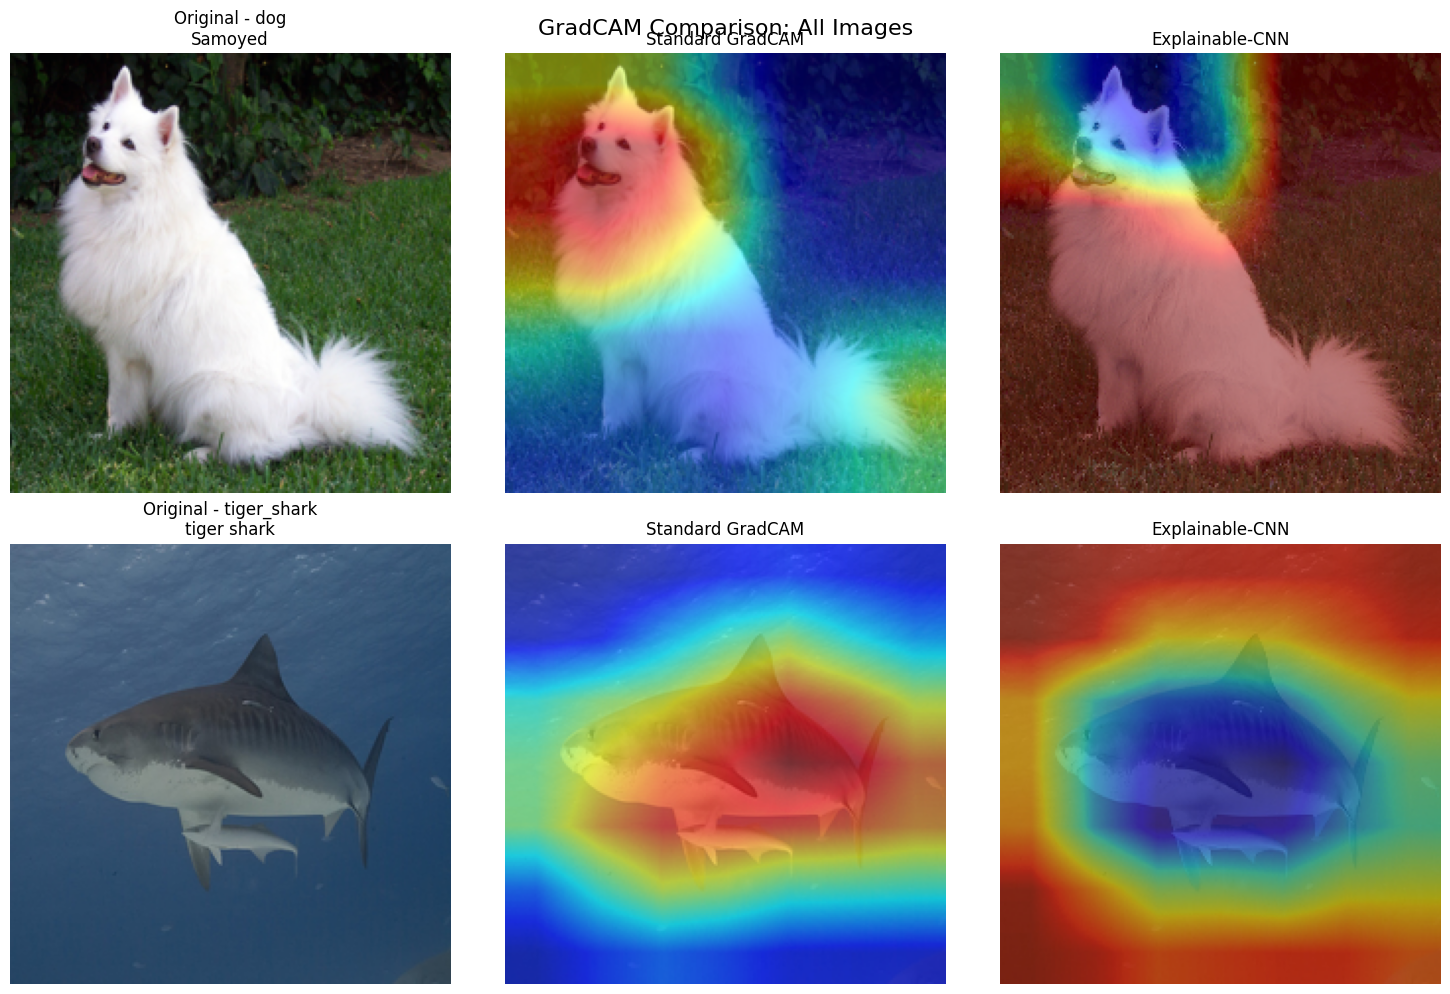

In [9]:
#!/usr/bin/env python3

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import InterpolationMode
from torchvision.transforms._presets import ImageClassification
try:
    from torchvision.transforms._presets import DefaultClassificationPresetEval
except ImportError:
    # Fallback for older torchvision versions
    DefaultClassificationPresetEval = ImageClassification
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from explainable_cnn import CNNExplainer

def load_imagenet_classes():
    try:
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        classes = response.text.strip().split('\n')
        class_labels = {i: label for i, label in enumerate(classes)}
        return classes, class_labels
    except:
        classes = [f"class_{i}" for i in range(1000)]
        class_labels = {i: f"class_{i}" for i in range(1000)}
        return classes, class_labels

def setup_model():
    device = torch.device('cpu')
    model = models.resnet50(pretrained=True)
    model.eval()
    model = model.to(device)

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return model, preprocess, device

def setup_custom_model(checkpoint_path):
    device = torch.device('cpu')
    ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    model = models.get_model(ckpt['args'].model,
                             num_classes=ckpt['model']['fc.weight'].shape[0])
    model.load_state_dict(ckpt['model'])
    model.eval()
    model = model.to(device)

    preprocessing = DefaultClassificationPresetEval(
        crop_size=ckpt['args'].val_crop_size,
        resize_size=ckpt['args'].val_resize_size,
        interpolation=InterpolationMode(ckpt['args'].interpolation)
    )

    return model, preprocessing, device

def get_prediction(model, img_tensor, device):
    if isinstance(img_tensor, torch.Tensor):
        input_batch = img_tensor.unsqueeze(0).to(device)
    else:
        input_batch = img_tensor.to(device)

    with torch.no_grad():
        output = model(input_batch)
        predicted_class = output.argmax(dim=1).item()
    return predicted_class, input_batch

def get_standard_gradcam(model, input_batch, predicted_class, rgb_img):
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(predicted_class)]

    grayscale_cam = cam(input_tensor=input_batch, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Ensure rgb_img is the right size for overlay
    if rgb_img.shape[:2] != grayscale_cam.shape:
        from PIL import Image as PILImage
        rgb_img_resized = np.array(PILImage.fromarray((rgb_img * 255).astype(np.uint8)).resize((grayscale_cam.shape[1], grayscale_cam.shape[0]))) / 255.0
    else:
        rgb_img_resized = rgb_img

    return show_cam_on_image(rgb_img_resized, grayscale_cam, use_rgb=True)

def get_explainable_cnn_gradcam(model, img_path, class_labels):
    try:
        x_cnn = CNNExplainer(model, class_labels)
        grad_cam = x_cnn.get_grad_cam(img_path, 3, (224, 224), ["layer4"])
        return grad_cam[0].astype('uint8')
    except Exception as e:
        print(f"Error with explainable-cnn: {e}")
        return None

def create_combined_visualization():
    """Create a single plot with all image comparisons as rows"""
    print("\nCreating combined visualization...")

    # Store all results
    all_results = []

    # Process ImageNet images
    imagenet_classes, class_labels = load_imagenet_classes()
    model_imagenet, preprocess_imagenet, device = setup_model()

    for img_path in ["dog.jpg", "tiger_shark.jpeg"]:
        try:
            img = Image.open(img_path).convert('RGB')
            input_tensor = preprocess_imagenet(img)
            rgb_img = np.array(img.resize((224, 224))) / 255.0

            predicted_class, input_batch = get_prediction(model_imagenet, input_tensor, device)
            standard_gradcam = get_standard_gradcam(model_imagenet, input_batch, predicted_class, rgb_img)
            explainable_gradcam = get_explainable_cnn_gradcam(model_imagenet, img_path, class_labels)

            all_results.append({
                'name': img_path.split('.')[0],
                'original': rgb_img,
                'standard': standard_gradcam,
                'explainable': explainable_gradcam,
                'title': f'{imagenet_classes[predicted_class]}'
            })
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Process custom model images
    try:
        checkpoint_path = "spores_model_cv_1_37.pth"
        model_custom, preprocess_custom, device = setup_custom_model(checkpoint_path)
        num_classes = model_custom.fc.out_features
        custom_class_labels = {i: f"class_{i}" for i in range(num_classes)}

        for img_path in ["A12A_x2700_007.png", "E14F.png", "F13G.png"]:
            try:
                img = Image.open(img_path).convert('RGB')
                input_tensor = preprocess_custom(img)
                rgb_img = np.array(img.resize((224, 224))) / 255.0

                predicted_class, input_batch = get_prediction(model_custom, input_tensor, device)
                standard_gradcam = get_standard_gradcam(model_custom, input_batch, predicted_class, rgb_img)
                explainable_gradcam = get_explainable_cnn_gradcam(model_custom, img_path, custom_class_labels)

                all_results.append({
                    'name': img_path.split('.')[0],
                    'original': rgb_img,
                    'standard': standard_gradcam,
                    'explainable': explainable_gradcam,
                    'title': f'Class {predicted_class}'
                })
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    except Exception as e:
        print(f"Error loading custom model: {e}")

    # Create combined plot
    n_images = len(all_results)
    if n_images == 0:
        print("No images processed successfully")
        return

    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
    if n_images == 1:
        axes = axes.reshape(1, -1)

    for i, result in enumerate(all_results):
        # Original
        axes[i, 0].imshow(result['original'])
        axes[i, 0].set_title(f"Original - {result['name']}\n{result['title']}")
        axes[i, 0].axis('off')

        # Standard GradCAM
        axes[i, 1].imshow(result['standard'])
        axes[i, 1].set_title('Standard GradCAM')
        axes[i, 1].axis('off')

        # Explainable-CNN
        if result['explainable'] is not None:
            axes[i, 2].imshow(result['explainable'])
            axes[i, 2].set_title('Explainable-CNN')
        else:
            axes[i, 2].text(0.5, 0.5, 'Failed', ha='center', va='center', transform=axes[i, 2].transAxes)
            axes[i, 2].set_title('Explainable-CNN (Error)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.suptitle('GradCAM Comparison: All Images', fontsize=16, y=0.98)
    plt.show()

def process_image(image_path):
    print(f"Processing {image_path} with ImageNet model...")

    imagenet_classes, class_labels = load_imagenet_classes()
    model, preprocess, device = setup_model()

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img)
    rgb_img = np.array(img.resize((224, 224))) / 255.0

    # Get prediction
    predicted_class, input_batch = get_prediction(model, input_tensor, device)

    # Generate GradCAMs
    standard_gradcam = get_standard_gradcam(model, input_batch, predicted_class, rgb_img)
    explainable_gradcam = get_explainable_cnn_gradcam(model, image_path, class_labels)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f'Original\n{imagenet_classes[predicted_class]}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(standard_gradcam)
    plt.title('Standard GradCAM')
    plt.axis('off')

    if explainable_gradcam is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(explainable_gradcam)
        plt.title('Explainable-CNN')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def process_custom_image(image_path, checkpoint_path):
    print(f"Processing {image_path} with custom model...")

    model, preprocess, device = setup_custom_model(checkpoint_path)

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(img)

    # For display purposes, resize to 224x224
    display_img = img.resize((224, 224))
    rgb_img = np.array(display_img) / 255.0

    # Get prediction
    predicted_class, input_batch = get_prediction(model, input_tensor, device)

    # Create dummy class labels for custom model
    num_classes = model.fc.out_features
    custom_class_labels = {i: f"class_{i}" for i in range(num_classes)}

    # Generate GradCAMs
    standard_gradcam = get_standard_gradcam(model, input_batch, predicted_class, rgb_img)
    explainable_gradcam = get_explainable_cnn_gradcam(model, image_path, custom_class_labels)

    # Display results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_img)
    plt.title(f'Original\nPredicted class: {predicted_class}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(standard_gradcam)
    plt.title('Standard GradCAM')
    plt.axis('off')

    if explainable_gradcam is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(explainable_gradcam)
        plt.title('Explainable-CNN')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Process ImageNet images
    print("=" * 50)
    print("PROCESSING IMAGENET IMAGES")
    print("=" * 50)
    process_image("dog.jpg")
    process_image("tiger_shark.jpeg")

    # Process custom model images
    print("\n" + "=" * 50)
    print("PROCESSING SPORE IMAGES WITH CUSTOM MODEL")
    print("=" * 50)
    checkpoint_path = "spores_model_cv_1_37.pth"

    custom_images = ["A12A_x2700_007.png", "E14F.png", "F13G.png"]
    for img_path in custom_images:
        try:
            process_custom_image(img_path, checkpoint_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Create combined visualization
    print("\n" + "=" * 50)
    print("CREATING COMBINED VISUALIZATION")
    print("=" * 50)
    create_combined_visualization()